# 합병증 분류 예측 모델링(Second outcome 기준)

## Colab & Drive Setting

In [1]:
# google drive 연동
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/MyDrive/숨고/윤현규님(합병증 예측)/2차 과제') # 해당 path는 환경에 맞게 변경해야 함

Mounted at /content/drive/


## Import Library

In [2]:
!pip install transformers
!pip install missingno

import pandas as pd, numpy as np, random, re, pickle
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.calibration import calibration_curve
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, PrecisionRecallDisplay, brier_score_loss
from sklearn.utils import class_weight
from imblearn.under_sampling import RandomUnderSampler 
from transformers import AutoTokenizer, AutoModel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import missingno as msno
nltk.download('stopwords')
nltk.download('punkt')

# tensorflow/keras
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, BatchNormalization
from keras.layers.advanced_activations import ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import AUC

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.1 MB/s 
     |████████████████████████████████| 120 kB 81.9 MB/s 
     |████████████████████████████████| 6.6 MB 71.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Data Load

In [ ]:
data = pd.read_excel("full_data_220907 (Ver1.1).xlsx")
data = data[[i for i in data.columns if i!='tb']]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185430 entries, 0 to 185429
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   caseid          185430 non-null  int64  
 1   first_outcome   185430 non-null  int64  
 2   second_outcome  185430 non-null  int64  
 3   yr              185430 non-null  int64  
 4   em              185430 non-null  int64  
 5   dm              185430 non-null  int64  
 6   htn             185430 non-null  int64  
 7   asa             172300 non-null  float64
 8   andur           184722 non-null  float64
 9   expd            185430 non-null  float64
 10  age             185430 non-null  float64
 11  sex             185430 non-null  int64  
 12  wt              183519 non-null  float64
 13  ht              183361 non-null  float64
 14  bm              180873 non-null  float64
 15  atype           185430 non-null  int64  
 16  hem             181630 non-null  float64
 17  wb        

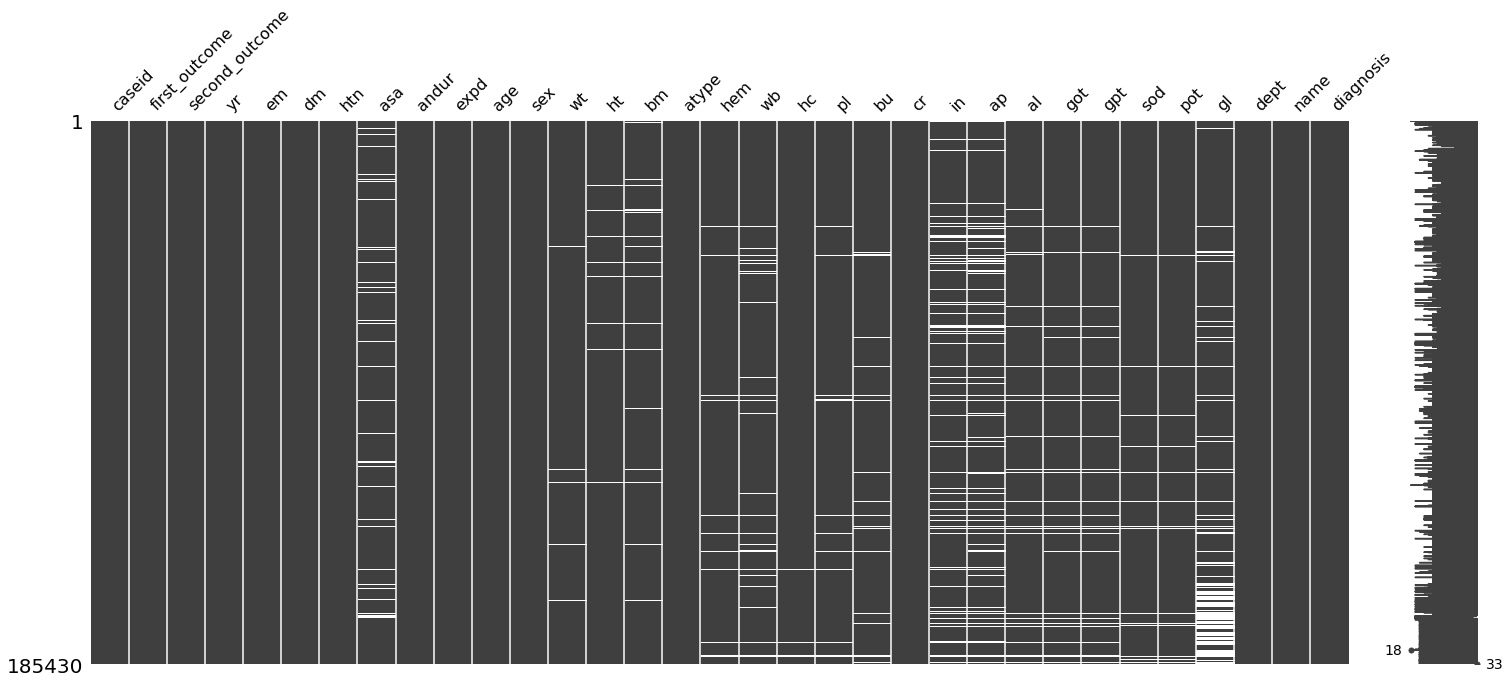

In [ ]:
# missing value visualization
msno.matrix(data)

## Fill NA

In [ ]:
# Fill NA with MICE
col = [i for i in data.columns if i not in ['caseid','dept','name','diagnosis']]

imp_algorithm = IterativeImputer(random_state=20220918)
imp_data = imp_algorithm.fit_transform(data[col])
imp_data = pd.DataFrame(imp_data, columns=col)
imp_data.loc[:,'asa'] = imp_data['asa'].round(1)
imp_data = pd.concat([imp_data, data[['caseid','dept','name','diagnosis']]],axis=1)

with open('./result/processed data/imputed_data_second.pickle', 'wb') as f:
    pickle.dump(imp_data, f)

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


In [ ]:
with open('./result/processed data/imputed_data_second.pickle', 'rb') as f:
    imp_data = pickle.load(f)

In [ ]:
imp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185430 entries, 0 to 185429
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   first_outcome   185430 non-null  float64
 1   second_outcome  185430 non-null  float64
 2   yr              185430 non-null  float64
 3   em              185430 non-null  float64
 4   dm              185430 non-null  float64
 5   htn             185430 non-null  float64
 6   asa             185430 non-null  float64
 7   andur           185430 non-null  float64
 8   expd            185430 non-null  float64
 9   age             185430 non-null  float64
 10  sex             185430 non-null  float64
 11  wt              185430 non-null  float64
 12  ht              185430 non-null  float64
 13  bm              185430 non-null  float64
 14  atype           185430 non-null  float64
 15  hem             185430 non-null  float64
 16  wb              185430 non-null  float64
 17  hc        

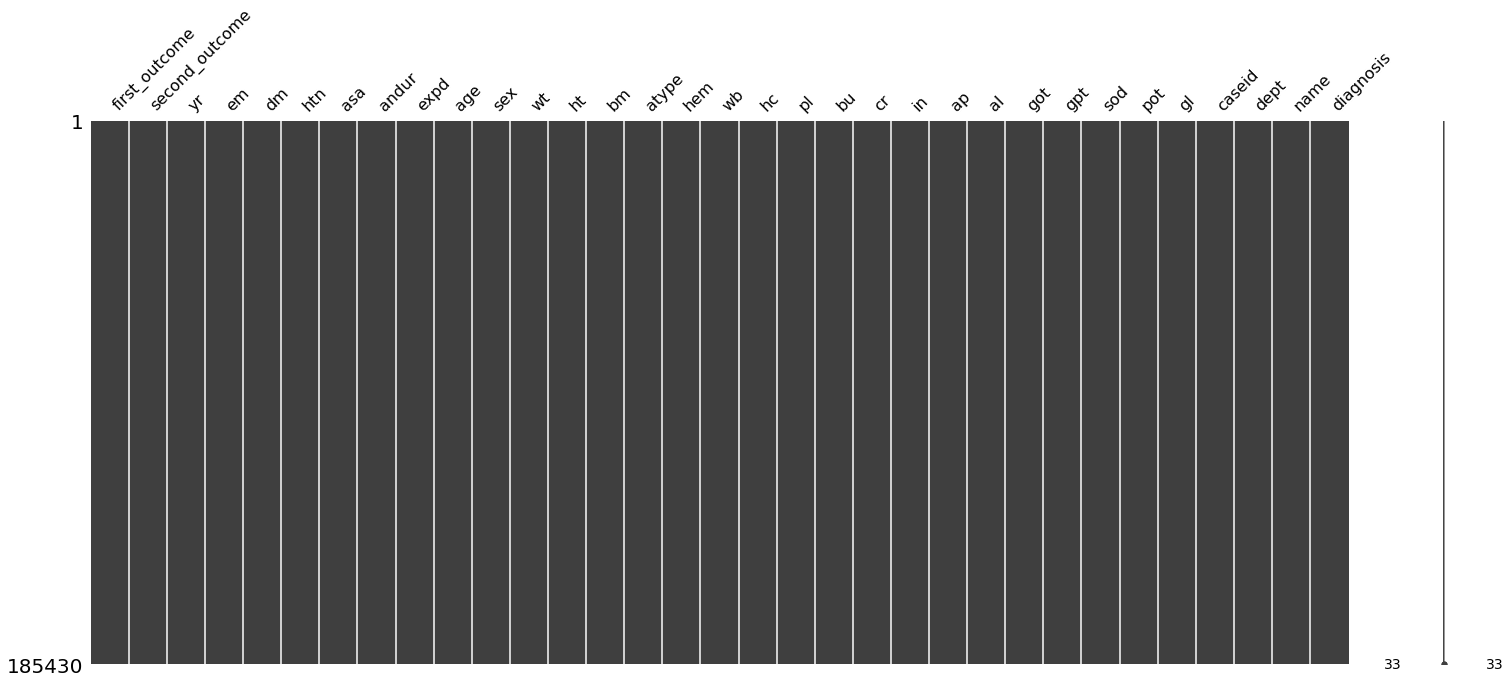

In [ ]:
# missing value visualization
msno.matrix(imp_data)

## Feature Engineering

In [ ]:
data_copied = imp_data.copy()

In [ ]:
# Numerical Features Engineering

# yr, hem, pot 제외
data_copied = data_copied.drop(['yr', 'hem', 'pot'], axis=1)

In [ ]:
# Categorical Features Engineering

# dept
data_copied['dept_separate'] = data_copied['dept'].apply(lambda x : x if (x=='TS') | (x=='UR') else 'Others')
data_copied = data_copied.drop(['dept'], axis=1)

# one-hot-encoding
def onehot(df, col):
    onehot = OneHotEncoder(sparse=False)
    onehot_data = onehot.fit_transform(df[col].values.reshape(-1,1))
    onehot_data = pd.DataFrame(onehot_data, columns=[col + "_" + i for i in onehot.categories_])
    df = pd.concat([df, onehot_data], axis=1)
    df = df.drop([col], axis=1)

    return df

data_copied = onehot(data_copied, "dept_separate")

In [ ]:
# 수술명/진단명 통한 파생변수 생성(환자수 기준 3시그마 수술/진단명 리스트 중 합병증률 20%이상인 리스트 추출하여 해당하는 수술/진단명 환자는 1, 아닌 경우 0
name_list = pd.read_csv("수술명.csv")
data_copied['name_selected'] = data_copied['name'].apply(lambda x:1 if x in name_list.loc[name_list['rate']>=0.2,"name"].values else 0)

diag_list = pd.read_csv("진단명.csv")
data_copied['diag_selected'] = data_copied['diagnosis'].apply(lambda x:1 if x in diag_list.loc[diag_list['rate']>=0.2,"diagnosis"].values else 0)

In [ ]:
# NLP

# name 변수와 diagnosis 변수 내 특수문자만 제거 
data_copied['name_rmv'] = data_copied['name'].str.replace(pat=r'[^A-Za-z0-9]', repl=r' ', regex=True)
data_copied['diagnosis_rmv'] = data_copied['diagnosis'].str.replace(pat=r'[^A-Za-z0-9]', repl=r' ', regex=True)

data_copied = data_copied.drop(['name', 'diagnosis'], axis=1)

## Sampling(Random under sampling) : 텍스트가 존재하므로

In [ ]:
 # undersampling(sampling_strategy = minority_num / majority_num)
rus = RandomUnderSampler(sampling_strategy = 'majority', random_state=20220820)
X_res, y_res = rus.fit_resample(data_copied.drop(['second_outcome','first_outcome'],axis=1), data_copied['second_outcome'])

data_copied = pd.concat([X_res, pd.DataFrame(y_res)], axis=1).reset_index(drop=True)
data_copied.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


,em,dm,htn,asa,andur,expd,age,sex,wt,ht,...,gl,caseid,"(dept_separate_Others,)","(dept_separate_TS,)","(dept_separate_UR,)",name_selected,diag_selected,name_rmv,diagnosis_rmv,second_outcome
0,0.0,1.0,1.0,3.0,485.0,5.0,65.0,0.0,61.00,158.500000,...,171.00000,76568,0.0,1.0,0.0,0,0,Aortocoronary bypasss of two or more coronary ...,Stable angina,0.0
1,0.0,0.0,0.0,2.0,270.0,3.0,72.0,1.0,59.45,151.300000,...,89.00000,92617,1.0,0.0,0.0,0,0,Hilar resection prn left hemihepatectomy,Klatskin tumor,0.0
2,1.0,0.0,0.0,1.0,110.0,4.0,36.0,0.0,66.90,160.000000,...,107.00000,50097,1.0,0.0,0.0,0,0,micro discectomy,spinal stenosis of lumbar spine,0.0
3,0.0,0.0,0.0,2.0,280.0,5.0,69.5,1.0,51.95,155.300000,...,118.00000,147530,1.0,0.0,0.0,0,0,Midline suboccipital craniotomy and tumor remo...,Ependymoma of brain,0.0
4,0.0,0.0,0.0,1.0,230.0,2.5,53.0,1.0,47.60,156.700000,...,97.00000,6574,1.0,0.0,0.0,0,0,Proximal Gastrectomy poss TG,early gastric cancer,0.0
5,0.0,0.0,0.0,1.0,110.0,4.0,51.0,0.0,71.20,167.000000,...,136.00000,42246,1.0,0.0,0.0,0,0,debulking surgery liver co op,mesothelioma,0.0
6,0.0,0.0,0.0,2.0,188.0,3.0,65.0,0.0,75.80,164.900000,...,105.42115,173615,0.0,0.0,1.0,0,0,Robot assisted Prostatectomy radical roboti...,Prostate cancer,0.0
7,0.0,0.0,0.0,2.0,60.0,1.0,26.0,0.0,67.15,166.800000,...,95.00000,86011,1.0,0.0,0.0,0,0,A S 2nd look FBR Lt,Injury of anterior cruciate ligament,0.0
8,0.0,1.0,0.0,2.0,590.0,6.0,33.0,0.0,74.00,174.396098,...,147.43144,52365,1.0,0.0,0.0,0,0,MCA STA anastomosis,middle cerebral artery stenosis,0.0
9,0.0,0.0,1.0,2.0,370.0,4.0,71.0,1.0,59.80,152.600000,...,172.00000,81071,0.0,1.0,0.0,0,0,Excision of myxoma,Cardiac myxoma,0.0


In [ ]:
# Sentence embedding by 
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

def embedding(name_data, diag_data):
    name_list_data = name_data.values.reshape(-1).tolist()
    diag_list_data = diag_data.values.reshape(-1).tolist()
    name_result = np.zeros((1,768))
    diag_result = np.zeros((1,768))
    for i in range(0,len(name_list_data),100):
        print(i)
        name_encoded_input = tokenizer(name_list_data[i:i+100], padding=True, return_tensors='pt') # tokenize 결과를 tensor로 반환(모든 문장의 시작에 위치하는 CLS 토큰과 문장의 끝에 들어가는 SEP 토큰에 대한 index 포함)
        name_model_output = model(**name_encoded_input) # last_hidden_state : (batchsize, sequence size, vector size) / pooler_output : (batchsize,vector size), pooler_output은 CLS토큰에 대한 벡터값
        name_result = np.concatenate((name_result,name_model_output.pooler_output.detach().numpy()), axis=0)
        del name_model_output

        diag_encoded_input = tokenizer(diag_list_data[i:i+100], padding=True, return_tensors='pt') # tokenize 결과를 tensor로 반환(모든 문장의 시작에 위치하는 CLS 토큰과 문장의 끝에 들어가는 SEP 토큰에 대한 index 포함)
        diag_model_output = model(**diag_encoded_input) # last_hidden_state : (batchsize, sequence size, vector size) / pooler_output : (batchsize,vector size), pooler_output은 CLS토큰에 대한 벡터값
        diag_result = np.concatenate((diag_result,diag_model_output.pooler_output.detach().numpy()), axis=0)
        del diag_model_output

    return (name_result[1:,:], diag_result[1:,:])

name_embedding, diag_embedding = embedding(data_copied['name_rmv'], data_copied['diagnosis_rmv'])

data_copied = data_copied.drop(['name_rmv', 'diagnosis_rmv'], axis=1) 

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800


In [ ]:
# save
data_processed = data_copied.copy()
data_processed.to_csv('./result/processed data/data_processed_second.csv', index=False)

with open('./result/embedding data/name_embedding_second.pickle', 'wb') as f:
    pickle.dump(name_embedding, f)

with open('./result/embedding data/diag_embedding_second.pickle', 'wb') as f:
    pickle.dump(diag_embedding, f)

## Data loading for training


In [3]:
data_processed = pd.read_csv('./result/processed data/data_processed_second.csv')

with open('./result/embedding data/name_embedding_second.pickle', 'rb') as f:
    name_embedding = pickle.load(f)

with open('./result/embedding data/diag_embedding_second.pickle', 'rb') as f:
    diag_embedding = pickle.load(f)

data_total = pd.concat([data_processed, pd.DataFrame(name_embedding), pd.DataFrame(diag_embedding)], axis=1)

## Modeling

In [4]:
# train/validation/test split
x_train, x_test, y_train, y_test = train_test_split(data_total.drop(['second_outcome'], axis=1), data_total['second_outcome'], test_size=0.2, random_state=20220822, stratify=data_total['second_outcome'])
x_train_val, x_val, y_train_val, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=20220822, stratify=y_train)

train_id = x_train[['caseid']]
x_train_mlp = x_train_val[[i for i in x_train_val.iloc[:,:30].columns if i not in ['caseid', 'name_rmv', 'diagnosis_rmv']]]
x_train_name_emb = x_train_val.iloc[:,30:798]
x_train_diag_emb = x_train_val.iloc[:,798:]

x_val_mlp = x_val[[i for i in x_val.iloc[:,:30].columns if i not in ['caseid', 'name_rmv', 'diagnosis_rmv']]]
x_val_name_emb = x_val.iloc[:,30:798]
x_val_diag_emb = x_val.iloc[:,798:]

test_id = x_test[['caseid']]
x_test_mlp = x_test[[i for i in x_test.iloc[:,:30].columns if i not in ['caseid', 'name_rmv', 'diagnosis_rmv']]]
x_test_name_emb = x_test.iloc[:,30:798]
x_test_diag_emb = x_test.iloc[:,798:]

In [5]:
# feature scaling for DL
col = ['asa','age','wt','andur','expd','ht','bm','wb','hc','pl','bu','cr','in','ap','al','got','gpt','sod','gl']
mm = MinMaxScaler()
mm_train_data = mm.fit_transform(x_train_mlp[col])
mm_train_data = pd.DataFrame(mm_train_data, columns = col,index=x_train_mlp.index)
x_train_mlp[col] = mm_train_data

mm_val_data = mm.transform(x_val_mlp[col])
mm_val_data = pd.DataFrame(mm_val_data, columns = col,index=x_val_mlp.index)
x_val_mlp[col] = mm_val_data

mm_test_data = mm.transform(x_test_mlp[col])
mm_test_data = pd.DataFrame(mm_test_data, columns = col,index=x_test_mlp.index)
x_test_mlp[col] = mm_test_data

# feature scaling for ML
ml_train_y = y_train_val.copy()
ml_test_y = y_test.copy()
ml_train = x_train_val.copy()
ml_test = x_test.copy()
ml_train.columns = ml_train.columns[:30].tolist() + list(range(768*2))
ml_test.columns = ml_test.columns[:30].tolist() + list(range(768*2))

ml_mm = MinMaxScaler()
ml_mm_train_data = ml_mm.fit_transform(ml_train[ml_train.columns[30:]])
ml_mm_train_data = pd.DataFrame(ml_mm_train_data, columns = ml_train.columns[30:],index=ml_train.index)
ml_train[ml_train.columns[30:]] = ml_mm_train_data
ml_train = ml_train.drop(['caseid'],axis=1)

ml_mm_test_data = ml_mm.transform(ml_test[ml_test.columns[30:]])
ml_mm_test_data = pd.DataFrame(ml_mm_test_data, columns = ml_test.columns[30:],index=ml_test.index)
ml_test[ml_test.columns[30:]] = ml_mm_test_data
ml_test = ml_test.drop(['caseid'],axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

### Deep learning model

In [ ]:
# model architecture

# parameters 
emb_input_size = len(x_train_name_emb.columns) # 768
mlp_input_size = len(x_train_mlp.columns)
batch_size = 16
lr = 0.00001
epochs = 1000

# name process
name_input = Input(shape=emb_input_size)
name_model = Dense(256, kernel_initializer='he_normal')(name_input)
name_model = BatchNormalization()(name_model)
name_model = ReLU()(name_model)
# name_model = Dropout(0.2)(name_model)
name_model = Dense(128, kernel_initializer='he_normal')(name_model)
name_model = BatchNormalization()(name_model)
name_model = ReLU()(name_model)
# name_model = Dropout(0.2)(name_model)
name_model = Dense(16, kernel_initializer='he_normal')(name_model)
name_model = BatchNormalization()(name_model)
# name_model = Dropout(0.2)(name_model)
name_model = ReLU()(name_model)


# diag. process
diag_input = Input(shape=emb_input_size)
diag_model = Dense(256, kernel_initializer='he_normal')(diag_input)
diag_model = BatchNormalization()(diag_model)
diag_model = ReLU()(diag_model)
# diag_model = Dropout(0.2)(diag_model)
diag_model = Dense(128, kernel_initializer='he_normal')(diag_model)
diag_model = BatchNormalization()(diag_model)
diag_model = ReLU()(diag_model)
# diag_model = Dropout(0.2)(diag_model)
diag_model = Dense(16, kernel_initializer='he_normal')(diag_model)
diag_model = BatchNormalization()(diag_model)
# diag_model = Dropout(0.2)(diag_model)
diag_model = ReLU()(diag_model)

# mlp process
mlp_input = Input(shape=mlp_input_size)

# concatenate
dl_model = concatenate([name_model, diag_model, mlp_input])

# Dense layer
dl_model = Dense(512,kernel_initializer='he_normal')(dl_model)
dl_model = BatchNormalization()(dl_model)
dl_model = ReLU()(dl_model)
dl_model = Dropout(0.2)(dl_model)
dl_model = Dense(256,kernel_initializer='he_normal')(dl_model)
dl_model = BatchNormalization()(dl_model)
dl_model = ReLU()(dl_model)
dl_model = Dropout(0.2)(dl_model)
dl_model = Dense(64,kernel_initializer='he_normal')(dl_model)
dl_model = BatchNormalization()(dl_model)
dl_model = ReLU()(dl_model)

# output layer
output = Dense(1, activation='sigmoid')(dl_model) # sigmoid를 통한 확률 계산

# final model
dl_model = Model(inputs=[name_input, diag_input, mlp_input], outputs=[output])


# optimizer
optimizer = optimizers.Adam(learning_rate=lr)

# model의 loss function, 사용할 optimizer, metirc 정의
dl_model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=[AUC()]) 

dl_model.summary() # 모델 전체 아키텍처 출력

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 dense_40 (Dense)               (None, 256)          196864      ['input_13[0][0]']               
                                                                                                  
 dense_43 (Dense)               (None, 256)          196864      ['input_14[0][0]']               
                                                                                            

In [ ]:
# 학습 중 최상의 모델을 저장할 경로
best_weights_file="./result/model/weights_second.best.hdf5"

# 학습 중 validation acc 기준 최상의 모델을 저장하도록 checkpoint 설정
checkpoint = ModelCheckpoint(best_weights_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)

# model 학습 설정 및 학습 진행
history = dl_model.fit([x_train_name_emb, x_train_diag_emb, x_train_mlp], y_train_val,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[checkpoint, es],
                    verbose=1,
                    validation_data=([x_val_name_emb,x_val_diag_emb,x_val_mlp],y_val))

Epoch 1/1000
172/172 [==============================] - ETA: 0s - loss: 0.8721 - auc_4: 0.5392
Epoch 1: val_loss improved from inf to 0.71503, saving model to ./result/model/weights_second.best.hdf5
172/172 [==============================] - 6s 16ms/step - loss: 0.8721 - auc_4: 0.5392 - val_loss: 0.7150 - val_auc_4: 0.5355
Epoch 2/1000
172/172 [==============================] - ETA: 0s - loss: 0.8367 - auc_4: 0.5747
Epoch 2: val_loss did not improve from 0.71503
172/172 [==============================] - 2s 9ms/step - loss: 0.8367 - auc_4: 0.5747 - val_loss: 0.7208 - val_auc_4: 0.6378
Epoch 3/1000
172/172 [==============================] - ETA: 0s - loss: 0.8051 - auc_4: 0.6094
Epoch 3: val_loss improved from 0.71503 to 0.67762, saving model to ./result/model/weights_second.best.hdf5
172/172 [==============================] - 2s 10ms/step - loss: 0.8051 - auc_4: 0.6094 - val_loss: 0.6776 - val_auc_4: 0.7031
Epoch 4/1000
171/172 [============================>.] - ETA: 0s - loss: 0.7741 

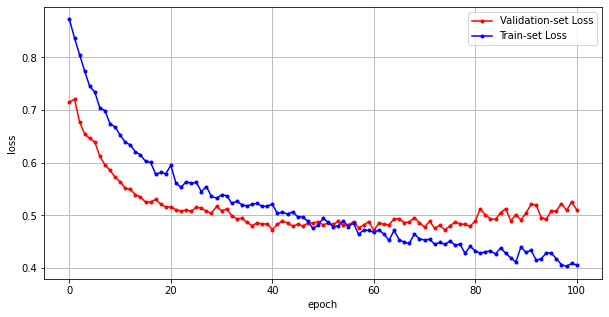

In [ ]:
# loss 그래프 출력
y_vloss = history.history['val_loss'] # 학습 중 validation loss 저장
y_loss = history.history['loss'] # 학습 중 train loss 저장
x_len = np.arange(len(y_loss)) # 전체 epoch 길이 저장

plt.figure(figsize=(10,5))
# validation loss에 대한 그래프 출력
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
# train loss에 대한 그래프 출력
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
# 저장된 deeplearning model load
best_weights_file="./result/model/weights_second.best.hdf5"
dl_model.load_weights(best_weights_file)

### RandomForest model

In [ ]:
rf_model = RandomForestClassifier(random_state=20220916)
param_grid = { 
    'n_estimators': [50,100,300,500,1000]
}

rf_grid = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv= 5, n_jobs=-1)
rf_grid.fit(ml_train, ml_train_y)

rf_model = RandomForestClassifier(n_estimators=rf_grid.best_params_['n_estimators'], random_state=20220916, n_jobs=-1)
rf_model.fit(ml_train, ml_train_y)

with open('./result/model/rf_model_embedding_second.pickle', 'wb') as f:
    pickle.dump(rf_model, f)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
# without embedding data

rf_model_no_emb = RandomForestClassifier(random_state=20220916, n_jobs=-1)
param_grid = { 
    'n_estimators': [50,100,300,500,1000]
}

rf_grid_no_emb = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv= 5, n_jobs=-1)
rf_grid_no_emb.fit(ml_train.iloc[:,:29], ml_train_y)

rf_model_no_emb = RandomForestClassifier(n_estimators=rf_grid_no_emb.best_params_['n_estimators'], random_state=20220916, n_jobs=-1)
rf_model_no_emb.fit(ml_train.iloc[:,:29], ml_train_y)

with open('./result/model/rf_model_no_embedding_second.pickle', 'wb') as f:
    pickle.dump(rf_model_no_emb, f)

In [6]:
# 저장된 rf model load
with open('./result/model/rf_model_embedding_second.pickle', 'rb') as f:
    rf_model_emb = pickle.load(f)

with open('./result/model/rf_model_no_embedding_second.pickle', 'rb') as f:
    rf_model_no_emb = pickle.load(f)

### LightGBM model

In [ ]:
# with embedding data
lgbm_model = lgb.LGBMClassifier(random_state=20220916,n_jobs=-1)
param_grid = {'learning_rate':[0.05,0.1,0.2]}

lgbm_grid = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, cv= 5, n_jobs=-1)
lgbm_grid.fit(ml_train, ml_train_y)

lgbm_model = lgb.LGBMClassifier(learning_rate=lgbm_grid.best_params_['learning_rate'], random_state=20220916, n_jobs=-1)
lgbm_model.fit(ml_train, ml_train_y)

with open('./result/model/lgbm_model_embedding_second.pickle', 'wb') as f:
    pickle.dump(lgbm_model, f)

In [ ]:
# without embedding data

lgbm_model_no_emb = lgb.LGBMClassifier(random_state=20220916, n_jobs=-1)
param_grid = {'learning_rate':[0.05,0.1,0.2]}

lgbm_grid_no_emb = GridSearchCV(estimator=lgbm_model_no_emb, param_grid=param_grid, cv= 5, n_jobs=-1)
lgbm_grid_no_emb.fit(ml_train.iloc[:,:29], ml_train_y)

lgbm_model_no_emb = lgb.LGBMClassifier(learning_rate=lgbm_grid_no_emb.best_params_['learning_rate'], random_state=20220916, n_jobs=-1)
lgbm_model_no_emb.fit(ml_train.iloc[:,:29], ml_train_y)

with open('./result/model/lgbm_model_no_embedding_second.pickle', 'wb') as f:
    pickle.dump(lgbm_model_no_emb, f)

In [7]:
# 저장된 lgmb model load
with open('./result/model/lgbm_model_embedding_second.pickle', 'rb') as f:
    lgbm_model_emb = pickle.load(f)

with open('./result/model/lgbm_model_no_embedding_second.pickle', 'rb') as f:
    lgbm_model_no_emb = pickle.load(f)

### XGBoost model

In [ ]:
# with embedding data
xgb_model = XGBClassifier(random_state=20220916, n_jobs=-1)
param_grid = {'n_estimators' : [100,300,500],'learning_rate' : [0.01,0.1]}

xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv= 5, n_jobs=-1)
xgb_grid.fit(ml_train, ml_train_y)

xgb_model = XGBClassifier(n_estimators=xgb_grid.best_params_['n_estimators'], learning_rate=xgb_grid.best_params_['learning_rate'], random_state=20220916, n_jobs=-1)
xgb_model.fit(ml_train, ml_train_y)

with open('./result/model/xgb_model_embedding_second.pickle', 'wb') as f:
    pickle.dump(xgb_model, f)

In [ ]:
# without embedding data

xgb_model_no_emb = XGBClassifier(random_state=20220916, n_jobs=-1)
param_grid = {'n_estimators' : [100,300,500],'learning_rate' : [0.01,0.1]}

xgb_grid_no_emb = GridSearchCV(estimator=xgb_model_no_emb, param_grid=param_grid, cv= 5, n_jobs=-1)
xgb_grid_no_emb.fit(ml_train.iloc[:,:29], ml_train_y)

xgb_model_no_emb = XGBClassifier(n_estimators=xgb_grid_no_emb.best_params_['n_estimators'], learning_rate=xgb_grid_no_emb.best_params_['learning_rate'], random_state=20220916, n_jobs=-1)
xgb_model_no_emb.fit(ml_train.iloc[:,:29], ml_train_y)

with open('./result/model/xgb_model_no_embedding_second.pickle', 'wb') as f:
    pickle.dump(xgb_model_no_emb, f)

In [8]:
# 저장된 xgboost model load
with open('./result/model/xgb_model_embedding_second.pickle', 'rb') as f:
    xgb_model_emb = pickle.load(f)

with open('./result/model/xgb_model_no_embedding_second.pickle', 'rb') as f:
    xgb_model_no_emb = pickle.load(f)

## Evaluation

### deep learning model

In [ ]:
 # Metrics for confusion matrix
y_dl_pred = pd.DataFrame(dl_model.predict([x_test_name_emb, x_test_diag_emb, x_test_mlp]),columns=['predict_second_outcome'])
y_dl_pred[y_dl_pred['predict_second_outcome']>=0.5] = 1
y_dl_pred[y_dl_pred['predict_second_outcome']<0.5] = 0
target_names = ['0','1']
print(classification_report(y_test, y_dl_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       381
           1       0.76      0.71      0.74       382

    accuracy                           0.74       763
   macro avg       0.74      0.74      0.74       763
weighted avg       0.74      0.74      0.74       763



In [ ]:
# brier score loss(0~1 사이 범위를 가지며 0에 가까울수록 완벽한 분류모델
print("Brier score : ", brier_score_loss(y_test, dl_model.predict([x_test_name_emb, x_test_diag_emb, x_test_mlp])))

Brier score :  0.17262784275678938


AUROC :  0.74


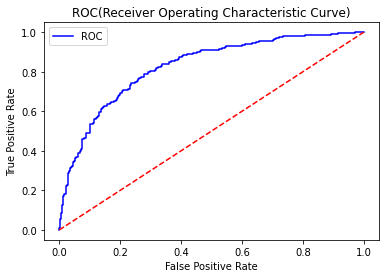

In [ ]:
# auroc
dl_auroc_score = roc_auc_score(y_test, y_dl_pred, average=None)
print("AUROC : ", round(dl_auroc_score,2))

# roc curve graph
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC(Receiver Operating Characteristic Curve)')
    plt.legend()
    plt.show()

prob = dl_model.predict([x_test_name_emb, x_test_diag_emb, x_test_mlp])
fper, tper, thresholds = roc_curve(y_test, prob)
plot_roc_curve(fper, tper)

AUPRC :  0.81


Text(0.5, 1.0, 'PRC(Precision Recall Curve)')

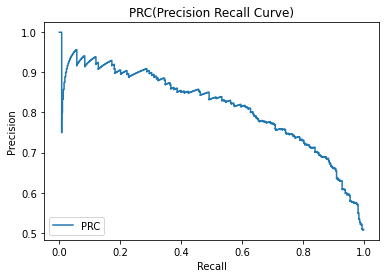

In [ ]:
# auprc
dl_auprc_score = average_precision_score(y_test, dl_model.predict([x_test_name_emb, x_test_diag_emb, x_test_mlp]), average=None)
print("AUPRC : ", round(dl_auprc_score,2))

# precision recall curve graph
_, ax = plt.subplots(figsize=(6, 4))
precision, recall, _ = precision_recall_curve(y_test, dl_model.predict([x_test_name_emb, x_test_diag_emb, x_test_mlp]))
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot(ax=ax, name='PRC')
ax.set_title('PRC(Precision Recall Curve)')

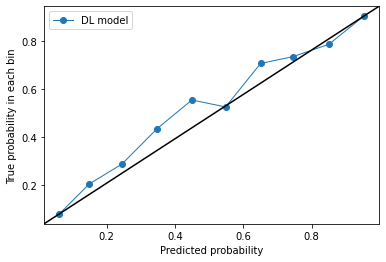

In [ ]:
# calibration curve
cal_y, cal_x = calibration_curve(y_test, dl_model.predict([x_test_name_emb, x_test_diag_emb, x_test_mlp]), n_bins=10)

_, ax = plt.subplots(figsize=(6, 4))
plt.plot(cal_x,cal_y,marker='o',linewidth=1,label='DL model')
line = mlines.Line2D([0,1], [0,1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
ax.set_xlabel("Predicted probability")
ax.set_ylabel("True probability in each bin")
plt.legend()
plt.show()

### randomforest model(with embedding)

In [15]:
 # Metrics for confusion matrix
y_rf_pred = pd.DataFrame(rf_model_emb.predict(ml_test), columns=['predict_second_outcome'])
y_rf_pred[y_rf_pred['predict_second_outcome']>=0.5] = 1
y_rf_pred[y_rf_pred['predict_second_outcome']<0.5] = 0
target_names = ['0','1']
print(classification_report(ml_test_y, y_rf_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


              precision    recall  f1-score   support

           0       0.75      0.79      0.77       381
           1       0.78      0.73      0.76       382

    accuracy                           0.76       763
   macro avg       0.76      0.76      0.76       763
weighted avg       0.76      0.76      0.76       763



In [ ]:
# brier score loss(0~1 사이 범위를 가지며 0에 가까울수록 완벽한 분류모델
print("Brier score : ", brier_score_loss(y_test, rf_model_emb.predict_proba(ml_test)[:,1]))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Brier score :  0.17320317169069463


AUROC :  0.76


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


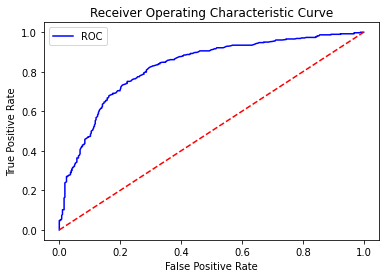

In [17]:
# auroc
rf_auroc_score = roc_auc_score(ml_test_y, y_rf_pred, average=None)
print("AUROC : ", round(rf_auroc_score,2))

# roc curve graph
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

prob = rf_model_emb.predict_proba(ml_test)[:,1]
fper, tper, thresholds = roc_curve(ml_test_y, prob)
plot_roc_curve(fper, tper)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


AUPRC :  0.81


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Text(0.5, 1.0, 'PRC(Precision Recall Curve)')

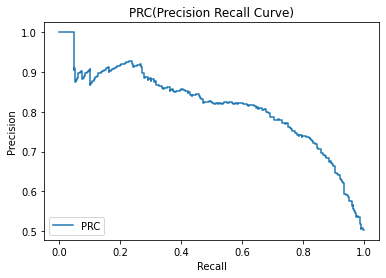

In [ ]:
# auprc
rf_auprc_score = average_precision_score(y_test,  rf_model_emb.predict_proba(ml_test)[:,1], average=None)
print("AUPRC : ", round(rf_auprc_score,2))

# precision recall curve graph
_, ax = plt.subplots(figsize=(6, 4))
precision, recall, _ = precision_recall_curve(y_test,  rf_model_emb.predict_proba(ml_test)[:,1])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot(ax=ax, name='PRC')
ax.set_title('PRC(Precision Recall Curve)')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


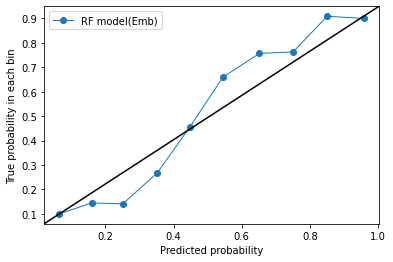

In [ ]:
# calibration curve
cal_y, cal_x = calibration_curve(y_test, rf_model_emb.predict_proba(ml_test)[:,1], n_bins=10)

_, ax = plt.subplots(figsize=(6, 4))
plt.plot(cal_x,cal_y,marker='o',linewidth=1,label='RF model(Emb)')
line = mlines.Line2D([0,1], [0,1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
ax.set_xlabel("Predicted probability")
ax.set_ylabel("True probability in each bin")
plt.legend()
plt.show()

### randomforest model(without embedding)

In [19]:
 # Metrics for confusion matrix
y_rf_noemb_pred = pd.DataFrame(rf_model_no_emb.predict(ml_test.iloc[:,:29]), columns=['predict_second_outcome'])
y_rf_noemb_pred[y_rf_noemb_pred['predict_second_outcome']>=0.5] = 1
y_rf_noemb_pred[y_rf_noemb_pred['predict_second_outcome']<0.5] = 0
target_names = ['0','1']
print(classification_report(ml_test_y, y_rf_noemb_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       381
           1       0.78      0.78      0.78       382

    accuracy                           0.78       763
   macro avg       0.78      0.78      0.78       763
weighted avg       0.78      0.78      0.78       763



In [20]:
# brier score loss(0~1 사이 범위를 가지며 0에 가까울수록 완벽한 분류모델
print("Brier score : ", brier_score_loss(y_test, rf_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1]))

Brier score :  0.14965341546526867


AUROC :  0.78


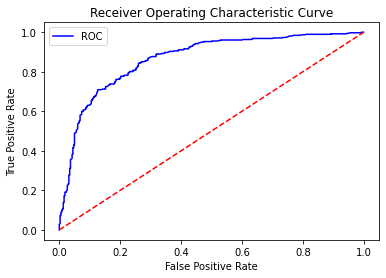

In [22]:
# auroc
rf_noemb_auroc_score = roc_auc_score(ml_test_y, y_rf_noemb_pred, average=None)
print("AUROC : ", round(rf_noemb_auroc_score,2))

# roc curve graph
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

prob = rf_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1]
fper, tper, thresholds = roc_curve(ml_test_y, prob)
plot_roc_curve(fper, tper)

AUPRC :  0.85


Text(0.5, 1.0, 'PRC(Precision Recall Curve)')

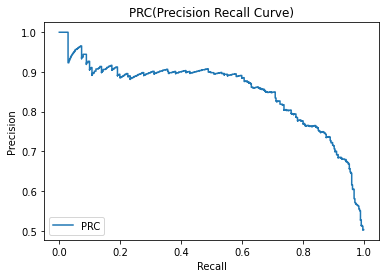

In [ ]:
# auprc
rf_noemb_auprc_score = average_precision_score(y_test, rf_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1], average=None)
print("AUPRC : ", round(rf_noemb_auprc_score,2))

# precision recall curve graph
_, ax = plt.subplots(figsize=(6, 4))
precision, recall, _ = precision_recall_curve(y_test, rf_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot(ax=ax, name='PRC')
ax.set_title('PRC(Precision Recall Curve)')

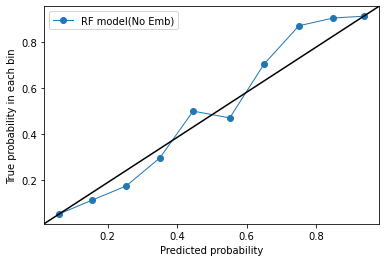

In [ ]:
# calibration curve
cal_y, cal_x = calibration_curve(y_test, rf_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1], n_bins=10)

_, ax = plt.subplots(figsize=(6, 4))
plt.plot(cal_x,cal_y,marker='o',linewidth=1,label='RF model(No Emb)')
line = mlines.Line2D([0,1], [0,1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
ax.set_xlabel("Predicted probability")
ax.set_ylabel("True probability in each bin")
plt.legend()
plt.show()

### Light GBM model(with embedding)

In [24]:
 # Metrics for confusion matrix
y_lgbm_pred = pd.DataFrame(lgbm_model_emb.predict(ml_test), columns=['predict_second_outcome'])
y_lgbm_pred[y_lgbm_pred['predict_second_outcome']>=0.5] = 1
y_lgbm_pred[y_lgbm_pred['predict_second_outcome']<0.5] = 0
target_names = ['0','1']
print(classification_report(ml_test_y, y_lgbm_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       381
           1       0.81      0.78      0.79       382

    accuracy                           0.80       763
   macro avg       0.80      0.80      0.80       763
weighted avg       0.80      0.80      0.80       763



In [25]:
# brier score loss(0~1 사이 범위를 가지며 0에 가까울수록 완벽한 분류모델
print("Brier score : ", brier_score_loss(y_test, lgbm_model_emb.predict_proba(ml_test)[:,1]))

Brier score :  0.14499779058535148


AUROC :  0.8


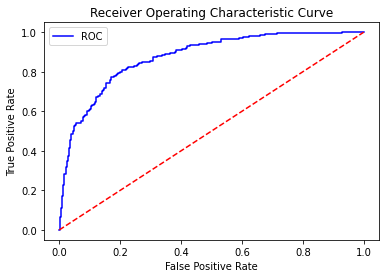

In [26]:
# auroc
lgbm_auroc_score = roc_auc_score(ml_test_y, y_lgbm_pred, average=None)
print("AUROC : ", round(lgbm_auroc_score,2))

# roc curve graph
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

prob = lgbm_model_emb.predict_proba(ml_test)[:,1]
fper, tper, thresholds = roc_curve(ml_test_y, prob)
plot_roc_curve(fper, tper)

AUPRC :  0.86


Text(0.5, 1.0, 'PRC(Precision Recall Curve)')

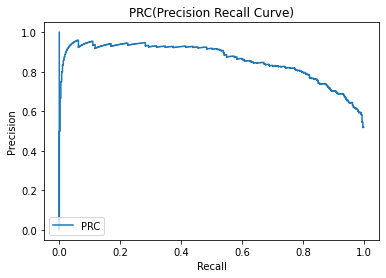

In [ ]:
# auprc
lgbm_auprc_score = average_precision_score(y_test, lgbm_model_emb.predict_proba(ml_test)[:,1], average=None)
print("AUPRC : ", round(lgbm_auprc_score,2))

# precision recall curve graph
_, ax = plt.subplots(figsize=(6, 4))
precision, recall, _ = precision_recall_curve(y_test, lgbm_model_emb.predict_proba(ml_test)[:,1])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot(ax=ax, name='PRC')
ax.set_title('PRC(Precision Recall Curve)')

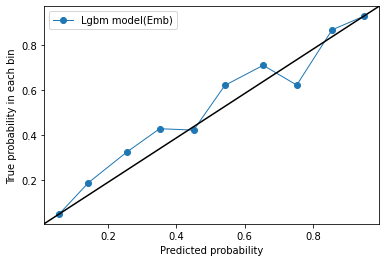

In [ ]:
# calibration curve
cal_y, cal_x = calibration_curve(y_test, lgbm_model_emb.predict_proba(ml_test)[:,1], n_bins=10)

_, ax = plt.subplots(figsize=(6, 4))
plt.plot(cal_x,cal_y,marker='o',linewidth=1,label='Lgbm model(Emb)')
line = mlines.Line2D([0,1], [0,1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
ax.set_xlabel("Predicted probability")
ax.set_ylabel("True probability in each bin")
plt.legend()
plt.show()

### Light GBM model(without embedding)

In [27]:
 # Metrics for confusion matrix
y_lgbm_noemb_pred = pd.DataFrame(lgbm_model_no_emb.predict(ml_test.iloc[:,:29]), columns=['predict_second_outcome'])
y_lgbm_noemb_pred[y_lgbm_noemb_pred['predict_second_outcome']>=0.5] = 1
y_lgbm_noemb_pred[y_lgbm_noemb_pred['predict_second_outcome']<0.5] = 0
target_names = ['0','1']
print(classification_report(ml_test_y, y_lgbm_noemb_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.77      0.78      0.77       381
           1       0.78      0.76      0.77       382

    accuracy                           0.77       763
   macro avg       0.77      0.77      0.77       763
weighted avg       0.77      0.77      0.77       763



In [28]:
# brier score loss(0~1 사이 범위를 가지며 0에 가까울수록 완벽한 분류모델
print("Brier score : ", brier_score_loss(y_test, lgbm_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1]))

Brier score :  0.16093302907988966


AUROC :  0.77


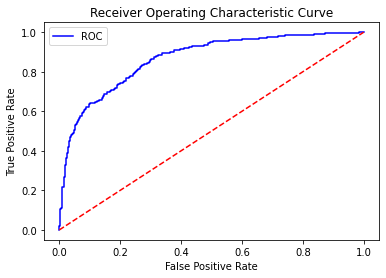

In [29]:
# auroc
lgbm_noemb_auroc_score = roc_auc_score(ml_test_y, y_lgbm_noemb_pred, average=None)
print("AUROC : ", round(lgbm_noemb_auroc_score,2))

# roc curve graph
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

prob = lgbm_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1]
fper, tper, thresholds = roc_curve(ml_test_y, prob)
plot_roc_curve(fper, tper)

AUPRC :  0.86


Text(0.5, 1.0, 'PRC(Precision Recall Curve)')

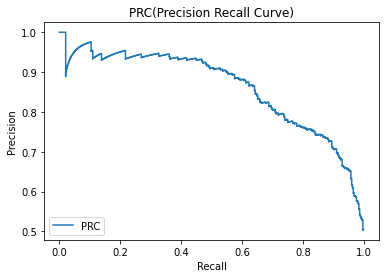

In [ ]:
# auprc
lgbm_noemb_auprc_score = average_precision_score(y_test, lgbm_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1], average=None)
print("AUPRC : ", round(lgbm_noemb_auprc_score,2))

# precision recall curve graph
_, ax = plt.subplots(figsize=(6, 4))
precision, recall, _ = precision_recall_curve(y_test, lgbm_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot(ax=ax, name='PRC')
ax.set_title('PRC(Precision Recall Curve)')

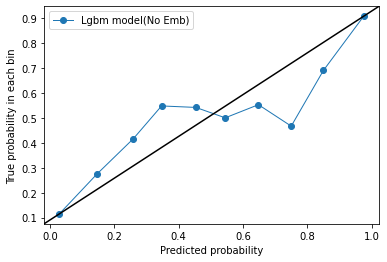

In [ ]:
# calibration curve
cal_y, cal_x = calibration_curve(y_test, lgbm_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1], n_bins=10)

_, ax = plt.subplots(figsize=(6, 4))
plt.plot(cal_x,cal_y,marker='o',linewidth=1,label='Lgbm model(No Emb)')
line = mlines.Line2D([0,1], [0,1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
ax.set_xlabel("Predicted probability")
ax.set_ylabel("True probability in each bin")
plt.legend()
plt.show()

### XGBoost model(with embedding)

In [30]:
 # Metrics for confusion matrix
y_xgb_pred = pd.DataFrame(xgb_model_emb.predict(ml_test), columns=['predict_second_outcome'])
y_xgb_pred[y_xgb_pred['predict_second_outcome']>=0.5] = 1
y_xgb_pred[y_xgb_pred['predict_second_outcome']<0.5] = 0
target_names = ['0','1']
print(classification_report(ml_test_y, y_xgb_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.77      0.82      0.79       381
           1       0.81      0.76      0.78       382

    accuracy                           0.79       763
   macro avg       0.79      0.79      0.79       763
weighted avg       0.79      0.79      0.79       763



In [31]:
# brier score loss(0~1 사이 범위를 가지며 0에 가까울수록 완벽한 분류모델
print("Brier score : ", brier_score_loss(y_test, xgb_model_emb.predict_proba(ml_test)[:,1]))

Brier score :  0.14958693236713022


AUROC :  0.79


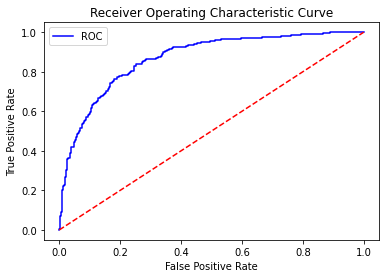

In [32]:
# auroc
xgb_auroc_score = roc_auc_score(ml_test_y, y_xgb_pred, average=None)
print("AUROC : ", round(xgb_auroc_score,2))

# roc curve graph
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

prob = xgb_model_emb.predict_proba(ml_test)[:,1]
fper, tper, thresholds = roc_curve(ml_test_y, prob)
plot_roc_curve(fper, tper)

AUPRC :  0.85


Text(0.5, 1.0, 'PRC(Precision Recall Curve)')

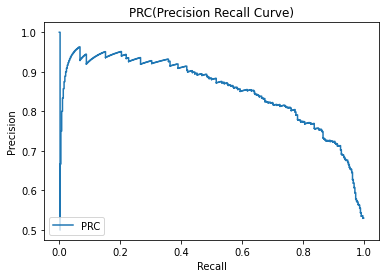

In [ ]:
# auprc
xgb_auprc_score = average_precision_score(y_test, xgb_model_emb.predict_proba(ml_test)[:,1], average=None)
print("AUPRC : ", round(xgb_auprc_score,2))

# precision recall curve graph
_, ax = plt.subplots(figsize=(6, 4))
precision, recall, _ = precision_recall_curve(y_test, xgb_model_emb.predict_proba(ml_test)[:,1])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot(ax=ax, name='PRC')
ax.set_title('PRC(Precision Recall Curve)')

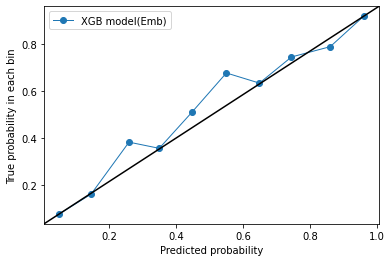

In [ ]:
# calibration curve
cal_y, cal_x = calibration_curve(y_test, xgb_model_emb.predict_proba(ml_test)[:,1], n_bins=10)

_, ax = plt.subplots(figsize=(6, 4))
plt.plot(cal_x,cal_y,marker='o',linewidth=1,label='XGB model(Emb)')
line = mlines.Line2D([0,1], [0,1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
ax.set_xlabel("Predicted probability")
ax.set_ylabel("True probability in each bin")
plt.legend()
plt.show()

### XGBoost model(without embedding)

In [33]:
 # Metrics for confusion matrix
y_xgb_noemb_pred = pd.DataFrame(xgb_model_no_emb.predict(ml_test.iloc[:,:29]), columns=['predict_second_outcome'])
y_xgb_noemb_pred[y_xgb_noemb_pred['predict_second_outcome']>=0.5] = 1
y_xgb_noemb_pred[y_xgb_noemb_pred['predict_second_outcome']<0.5] = 0
target_names = ['0','1']
print(classification_report(ml_test_y, y_xgb_noemb_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       381
           1       0.80      0.76      0.78       382

    accuracy                           0.79       763
   macro avg       0.79      0.79      0.79       763
weighted avg       0.79      0.79      0.79       763



In [34]:
# brier score loss(0~1 사이 범위를 가지며 0에 가까울수록 완벽한 분류모델
print("Brier score : ", brier_score_loss(y_test, xgb_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1]))

Brier score :  0.1457986308716056


AUROC :  0.79


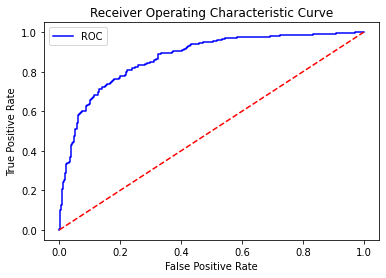

In [35]:
# auroc
xgb_noemb_auroc_score = roc_auc_score(ml_test_y, y_xgb_noemb_pred, average=None)
print("AUROC : ", round(xgb_noemb_auroc_score,2))

# roc curve graph
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

prob = xgb_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1]
fper, tper, thresholds = roc_curve(ml_test_y, prob)
plot_roc_curve(fper, tper)

AUPRC :  0.86


Text(0.5, 1.0, 'PRC(Precision Recall Curve)')

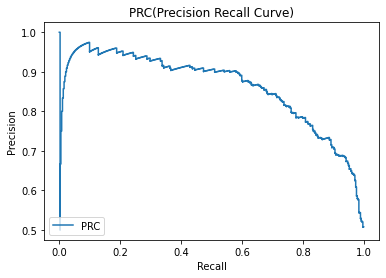

In [ ]:
# auprc
xgb_noemb_auprc_score = average_precision_score(y_test, xgb_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1], average=None)
print("AUPRC : ", round(xgb_noemb_auprc_score,2))

# precision recall curve graph
_, ax = plt.subplots(figsize=(6, 4))
precision, recall, _ = precision_recall_curve(y_test, xgb_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot(ax=ax, name='PRC')
ax.set_title('PRC(Precision Recall Curve)')

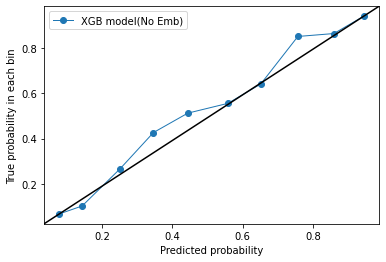

In [ ]:
# calibration curve
cal_y, cal_x = calibration_curve(y_test, xgb_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1], n_bins=10)

_, ax = plt.subplots(figsize=(6, 4))
plt.plot(cal_x,cal_y,marker='o',linewidth=1,label='XGB model(No Emb)')
line = mlines.Line2D([0,1], [0,1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
ax.set_xlabel("Predicted probability")
ax.set_ylabel("True probability in each bin")
plt.legend()
plt.show()